In [17]:
# Cell 1: Setup and Imports

import sys
import os
import numpy as np
import pandas as pd
import logging
import math # For sqrt

# --- Path Management ---
# Add the project root to sys.path to allow imports from src/
# Assuming the notebook is run from the 'notebooks' directory, or project root.
# Adjust 'project_root' if your notebook is deeper than 'notebooks'
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Add courselib path as well, if it's outside the project root structure
# (This assumes AppliedML is a sibling directory to your project directory)
courselib_path = os.path.abspath(os.path.join(project_root, '..', 'AppliedML'))
if courselib_path not in sys.path:
    sys.path.insert(0, courselib_path)

print(f"Current Working Directory: {os.getcwd()}")
print(f"Project Root Added to Path: {project_root}")
print(f"Courselib Path Added to Path: {courselib_path}")
print(f"sys.path: {sys.path}")


# --- Imports from your project ---
from src.data.data_processor import AirQualityProcessor
from src.features.feature_engineer import LagFeatureEngineer
from src.models.train_model_class_final import ModelEvaluator, custom_standard_scaler
from src.utils.config import TARGET_POLLUTANT, START_DATE, END_DATE, LAG_DEPTH
from src.visualization.analysis import plot_error_by_time_group

# --- Imports from courselib ---
from courselib.models.linear_models import LinearRegression
from courselib.optimizers import GDOptimizer
from courselib.utils.metrics import mean_squared_error, mean_absolute_error # Not strictly needed here, but good to have if you ever want custom metric printouts

# --- Imports from scikit-learn ---
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
from sklearn.linear_model import Ridge


# --- Logging Configuration ---
# Configure logging to display messages in the notebook output
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                    stream=sys.stdout) # Ensure logs go to stdout, visible in Jupyter
logger = logging.getLogger(__name__) # Get a logger for the notebook itself

print("Setup and Imports Complete!")

Current Working Directory: d:\Studium\Excercises\Applied ML\appliedML-air-quality\notebooks
Project Root Added to Path: d:\Studium\Excercises\Applied ML\appliedML-air-quality
Courselib Path Added to Path: d:\Studium\Excercises\Applied ML\AppliedML
sys.path: ['d:\\Studium\\Excercises\\Applied ML\\AppliedML', 'd:\\Studium\\Excercises\\Applied ML\\appliedML-air-quality\\notebooks', 'd:\\Studium\\Excercises\\Applied ML\\appliedML-air-quality\\AppliedML', 'd:\\Studium\\Excercises\\Applied ML\\appliedML-air-quality', 'C:\\Users\\user\\.conda\\envs\\applied_ml\\python310.zip', 'C:\\Users\\user\\.conda\\envs\\applied_ml\\DLLs', 'C:\\Users\\user\\.conda\\envs\\applied_ml\\lib', 'C:\\Users\\user\\.conda\\envs\\applied_ml', 'd:\\Studium\\Excercises\\Applied ML\\appliedML-air-quality\\.venv', '', 'd:\\Studium\\Excercises\\Applied ML\\appliedML-air-quality\\.venv\\lib\\site-packages', 'd:\\Studium\\Excercises\\Applied ML\\appliedML-air-quality\\.venv\\lib\\site-packages\\win32', 'd:\\Studium\\Excer

In [18]:
# Cell 2: Configuration

print("--- Pipeline Configuration ---")
print(f"Target Pollutant: {TARGET_POLLUTANT}")
print(f"Data Start Date: {START_DATE}")
print(f"Data End Date: {END_DATE}")
print(f"Lag Depth for Features: {LAG_DEPTH}")
print("-" * 30)

# Define training fraction for ModelEvaluator
TRAINING_DATA_FRACTION = 0.8
print(f"Training Data Fraction: {TRAINING_DATA_FRACTION}")
print("-" * 30)

--- Pipeline Configuration ---
Target Pollutant: NO2(GT)
Data Start Date: 10/03/2004
Data End Date: 08/06/2004
Lag Depth for Features: 24
------------------------------
Training Data Fraction: 0.8
------------------------------


In [19]:
# Cell 3: Data Processing

logger.info("--- Starting Data Processing ---")
processor = AirQualityProcessor(
    target_pollutant=TARGET_POLLUTANT,
    start_date=START_DATE,
    end_date=END_DATE
)
time_series = processor.get_target_time_series()
logger.info("AirQualityProcessor completed. Time series loaded.")
print(f"Time Series Head:\n{time_series.head()}")
print(f"Time Series Shape: {time_series.shape}")

2025-07-15 01:54:36,785 - INFO - --- Starting Data Processing ---
2025-07-15 01:54:37,012 - INFO - AirQualityProcessor completed. Time series loaded.


Raw data loaded and initially parsed.
Data prepared for NO2(GT) from 10/03/2004 to 08/06/2004.
Shape: (1716,), Missing values: 0

First 5 entries of prepared series:
DateTime
2004-03-10 18:00:00    113.0
2004-03-10 19:00:00     92.0
2004-03-10 20:00:00    114.0
2004-03-10 21:00:00    122.0
2004-03-10 22:00:00    116.0
Name: NO2(GT), dtype: float64

Last 5 entries of prepared series:
DateTime
2004-06-08 19:00:00    170.0
2004-06-08 20:00:00    143.0
2004-06-08 21:00:00    123.0
2004-06-08 22:00:00     89.0
2004-06-08 23:00:00     67.0
Name: NO2(GT), dtype: float64
Time Series Head:
DateTime
2004-03-10 18:00:00    113.0
2004-03-10 19:00:00     92.0
2004-03-10 20:00:00    114.0
2004-03-10 21:00:00    122.0
2004-03-10 22:00:00    116.0
Name: NO2(GT), dtype: float64
Time Series Shape: (1716,)


In [20]:
# Cell 4: Feature Engineering

logger.info("--- Starting Feature Engineering ---")
feature_engineer = LagFeatureEngineer(lag_depth=LAG_DEPTH)
df_lagged_features = feature_engineer.prepare_supervised_data(time_series, return_separate=False)
logger.info("LagFeatureEngineer completed. Supervised data prepared.")
print(f"Lagged DataFrame Head:\n{df_lagged_features.head()}")
print(f"Lagged DataFrame Shape: {df_lagged_features.shape}")

2025-07-15 01:54:37,046 - INFO - --- Starting Feature Engineering ---
2025-07-15 01:54:37,078 - INFO - LagFeatureEngineer completed. Supervised data prepared.


Generating 24 lag features and aligning target vector...
Lagged DataFrame Head:
                     Target  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  \
DateTime                                                                       
2004-03-11 19:00:00   172.0  151.0  135.0  131.0  126.0  128.0  112.0   95.0   
2004-03-11 20:00:00   165.0  172.0  151.0  135.0  131.0  126.0  128.0  112.0   
2004-03-11 21:00:00   136.0  165.0  172.0  151.0  135.0  131.0  126.0  128.0   
2004-03-11 22:00:00    85.0  136.0  165.0  172.0  151.0  135.0  131.0  126.0   
2004-03-11 23:00:00    53.0   85.0  136.0  165.0  172.0  151.0  135.0  131.0   

                     lag_8  lag_9  ...  lag_15  lag_16  lag_17  lag_18  \
DateTime                           ...                                   
2004-03-11 19:00:00   92.0   98.0  ...    34.0    60.0    76.0    77.0   
2004-03-11 20:00:00   95.0   92.0  ...    28.0    34.0    60.0    76.0   
2004-03-11 21:00:00  112.0   95.0  ...    48.0    28.0    34.0 

In [22]:
# Cell 5: Model Evaluation Setup

logger.info("--- Setting up Model Evaluator ---")
evaluator = ModelEvaluator(df_lagged_features, training_data_fraction=TRAINING_DATA_FRACTION)
logger.info("ModelEvaluator initialized with data splits.")
print(f"Train X scaled shape: {evaluator.train_X_scaled.shape}")
print(f"Test X scaled shape: {evaluator.test_X_scaled.shape}")
print(f"Train Y shape: {evaluator.train_Y_np.shape}")
print(f"Test Y shape: {evaluator.test_Y_np.shape}")

2025-07-15 01:54:45,368 - INFO - --- Setting up Model Evaluator ---
2025-07-15 01:54:45,372 - INFO - Performing data split and scaling...
2025-07-15 01:54:45,382 - INFO - Training data shape: X=(1354, 24), y=(1354,)
2025-07-15 01:54:45,384 - INFO - Testing data shape: X=(338, 24), y=(338,)
2025-07-15 01:54:45,385 - INFO - Test Y index shape: 338
2025-07-15 01:54:45,387 - INFO - ModelEvaluator initialized with data splits.


Train X scaled shape: (1354, 24)
Test X scaled shape: (338, 24)
Train Y shape: (1354,)
Test Y shape: (338,)


In [ ]:
# Cell 6: Model Training and Evaluation

logger.info("--- Starting Model Training and Evaluation ---")

# Courserlib Linear Regression
print("\nEvaluating Courserlib Linear Regression...")
optimizer = GDOptimizer(learning_rate=0.01)
# Note: Initial weights should match the number of features (LAG_DEPTH)
courselib_lr_model = LinearRegression(w=np.zeros(LAG_DEPTH), b=0.0, optimizer=optimizer)
evaluator.evaluate_model(
    "Linear Regression (courselib)", 
    courselib_lr_model, 
    is_courselib_model=True,
    num_epochs=2000, 
    batch_size=32
)

# Scikit-learn Linear Regression
print("\nEvaluating Scikit-learn Linear Regression...")
sklearn_lr_model = SklearnLinearRegression()
evaluator.evaluate_model("Scikit-learn Linear Regression", sklearn_lr_model)

# Scikit-learn Ridge Regression
print("\nEvaluating Scikit-learn Ridge Regression...")
ridge_model = Ridge(alpha=1.0) 
evaluator.evaluate_model("Scikit-learn Ridge Regression", ridge_model)

# Naive Baseline
print("\nEvaluating Naive Baseline...")
evaluator.evaluate_naive_baseline()

logger.info("--- All Model Evaluations Complete ---")

2025-07-15 01:56:42,701 - INFO - --- Starting Model Training and Evaluation ---
2025-07-15 01:56:42,704 - INFO - --- Starting evaluation for Linear Regression (courselib) ---



Evaluating Courserlib Linear Regression...


2025-07-15 01:56:47,968 - INFO - Model LinearRegression trained successfully.
2025-07-15 01:56:47,969 - INFO - Predictions generated for LinearRegression.
2025-07-15 01:56:47,970 - INFO - Model Linear Regression (courselib) - Test MSE: 137.2916, Test MAE: 12.9962, Test RMSE: 11.7171
2025-07-15 01:56:47,971 - INFO - --- Finished evaluation for Linear Regression (courselib) ---
2025-07-15 01:56:47,973 - INFO - --- Starting evaluation for Scikit-learn Linear Regression ---
2025-07-15 01:56:47,978 - INFO - Model LinearRegression trained successfully.
2025-07-15 01:56:47,981 - INFO - Predictions generated for LinearRegression.
2025-07-15 01:56:47,984 - INFO - Model Scikit-learn Linear Regression - Test MSE: 137.2350, Test MAE: 12.9937, Test RMSE: 11.7147
2025-07-15 01:56:47,986 - INFO - --- Finished evaluation for Scikit-learn Linear Regression ---
2025-07-15 01:56:47,989 - INFO - --- Starting evaluation for Scikit-learn Ridge Regression ---
2025-07-15 01:56:47,996 - INFO - Model Ridge trai


Evaluating Scikit-learn Linear Regression...

Evaluating Scikit-learn Ridge Regression...

Evaluating Naive Baseline...


In [26]:
# Cell 7: Results Summary

logger.info("\n--- Summary of All Model Results ---")
all_results = evaluator.get_results()

# Create a DataFrame for cleaner display
summary_data = []
for model_name, metrics_data in all_results.items():
    row = {"Model": model_name}
    # Filter out non-metric keys for display
    for k, v in metrics_data.items():
        if k not in ["model_object", "y_pred"]:
            row[k.upper()] = f"{v:.4f}" # Format metrics for consistent display
    summary_data.append(row)

results_df = pd.DataFrame(summary_data)
# Reorder columns to have Model first, then metrics
metric_cols = [col for col in results_df.columns if col != 'Model']
results_df = results_df[['Model'] + sorted(metric_cols)]

display(results_df)

2025-07-15 01:56:48,044 - INFO - 
--- Summary of All Model Results ---


,Model,MAE,MSE,RMSE
0,Linear Regression (courselib),12.9962,137.2916,11.7171
1,Scikit-learn Linear Regression,12.9937,137.2350,11.7147
2,Scikit-learn Ridge Regression,13.0057,137.4203,11.7226
3,Naive Baseline,13.8402,158.8669,12.6042


2025-07-15 01:57:47,749 - INFO - 
--- Starting Visualization ---
d:\Studium\Excercises\Applied ML\appliedML-air-quality\src\visualization\analysis.py:164: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_by_group = df.groupby('group').apply(lambda g: mean_absolute_error(g['y_true'], g['y_pred']))



Plotting error by hour for Linear Regression (courselib)...


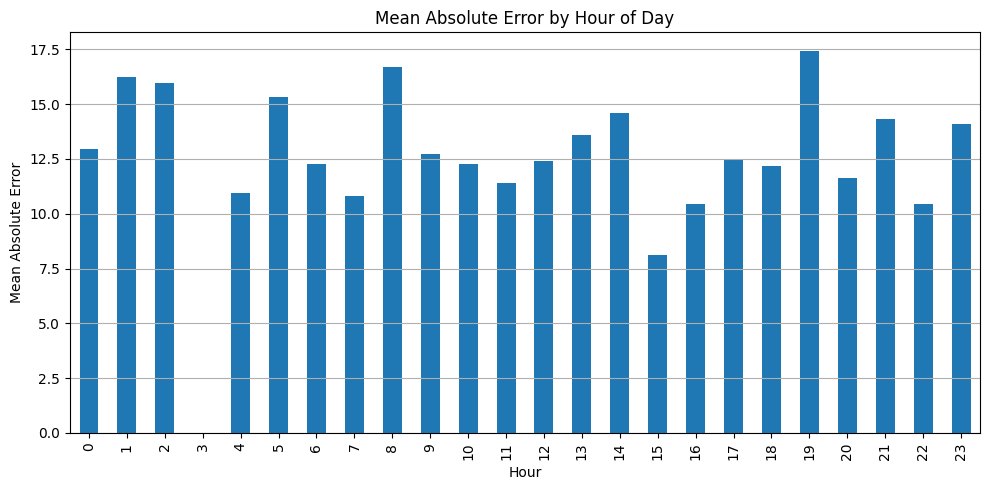


Plotting error by weekday for Scikit-learn Ridge Regression...


d:\Studium\Excercises\Applied ML\appliedML-air-quality\src\visualization\analysis.py:164: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_by_group = df.groupby('group').apply(lambda g: mean_absolute_error(g['y_true'], g['y_pred']))


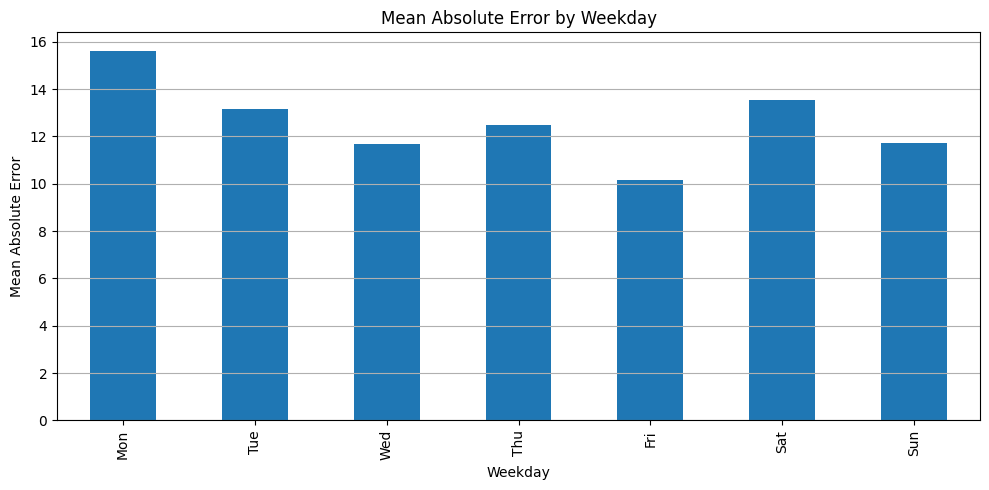

2025-07-15 01:57:49,243 - INFO - --- Visualization Complete ---


In [27]:
# Cell 8: Visualization - Error by Time Group (Example)

logger.info("\n--- Starting Visualization ---")

y_test_series_for_plot = evaluator.get_test_Y_series()

# Plot for Courserlib Linear Regression
y_pred_courselib_series = evaluator.get_predictions_series_for_model("Linear Regression (courselib)")
if not y_pred_courselib_series.empty:
    print("\nPlotting error by hour for Linear Regression (courselib)...")
    plot_error_by_time_group(y_test_series_for_plot, y_pred_courselib_series, group_by='hour')
else:
    logger.warning("No predictions available for Linear Regression (courselib) for plotting.")

# Plot for Scikit-learn Ridge Regression
y_pred_ridge_series = evaluator.get_predictions_series_for_model("Scikit-learn Ridge Regression")
if not y_pred_ridge_series.empty:
    print("\nPlotting error by weekday for Scikit-learn Ridge Regression...")
    plot_error_by_time_group(y_test_series_for_plot, y_pred_ridge_series, group_by='weekday')
else:
    logger.warning("No predictions available for Scikit-learn Ridge Regression for plotting.")

logger.info("--- Visualization Complete ---")